In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import colormaps  



In [2]:
import pandas as pd
from pathlib import Path

LOAD_PATH = Path("/root/capsule/scratch/all_tongue_movements/all_tongue_movements_16092025.parquet")

all_tongue_movements = pd.read_parquet(LOAD_PATH, engine="pyarrow")
print(all_tongue_movements.shape, all_tongue_movements.dtypes)

(40049, 45) movement_id                       Int64
start_time                      float64
end_time                        float64
duration                        float64
min_x                           float64
max_x                           float64
min_y                           float64
max_y                           float64
min_xv                          float64
max_xv                          float64
min_yv                          float64
max_yv                          float64
peak_velocity                   float64
mean_velocity                   float64
total_distance                  float64
startpoint_x                    float64
startpoint_y                    float64
endpoint_x                      float64
endpoint_y                      float64
time_to_endpoint                float64
excursion_angle_deg             float64
max_x_from_jaw                  float64
max_x_from_jaw_y                float64
max_y_from_jaw                  float64
max_y_from_jaw_x            

In [3]:
# LOAD INTERMEDIATE DATA

# # # User input: session folder
session_folder = "/root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14"

# Build paths
intermediate_dir = Path(session_folder) / "intermediate_data"
movements_path = intermediate_dir / "tongue_movs.parquet"
df_trials_path = intermediate_dir / "nwb_df_trials.parquet"
df_licks_path = intermediate_dir / "nwb_df_licks.parquet"

# Load dataframes
tongue_movements = pd.read_parquet(movements_path)
df_trials = pd.read_parquet(df_trials_path)
df_licks = pd.read_parquet(df_licks_path)


print(tongue_movements.columns)

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event'],
      dtype='object')


In [4]:
# example: time of first tongue movement on each trial:
df = tongue_movements.copy()

# Get first start_time per trial
first_start_times = df.groupby('trial', as_index=False).nth(0)[['trial', 'start_time']]

print(first_start_times)


      trial   start_time
20      0.0     0.190304
48      1.0    13.650272
88      2.0    29.780192
142     3.0    63.880128
220     4.0   136.206016
...     ...          ...
7232  581.0  5291.530560
7236  582.0  5297.304576
7238  583.0  5307.098528
7240  584.0  5314.612512
7243  585.0  5321.664512

[568 rows x 2 columns]


In [5]:
# example: whether first tongue movement is a lick (would be a cue response lick)
# Group by trial and get the first movement row for each trial
df = tongue_movements.copy()

first_movements = df.groupby('trial').nth(0).reset_index()

# Select only the trial, has_lick, and cue_response columns
first_movement_licks = first_movements[['trial', 'has_lick', 'cue_response']]
print(first_movement_licks)
#NB: cue_response == None means there was no lick detected by lickometer.

# # Sanity check: Find rows where has_lick is False and cue_response is True (should never happen)
# violation_rows = first_movement_licks[(first_movement_licks['has_lick'] == False) & (first_movement_licks['cue_response'] == True)]
# print(violation_rows)


     trial  has_lick cue_response
0      0.0     False         None
1      1.0      True         True
2      2.0     False         None
3      3.0     False         None
4      4.0     False         None
..     ...       ...          ...
563  581.0      True         True
564  582.0      True         True
565  583.0      True         True
566  584.0      True         True
567  585.0      True         True

[568 rows x 3 columns]


In [6]:
# example analysis

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements, annotate_movement_timing

# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


/src/aind-dynamic-foraging-behavior-video-analysis/src/aind_dynamic_foraging_behavior_video_analysis/kinematics/tongue_kinematics_utils.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[df['cue_response'].fillna(False)]


In [8]:
FIG_DIR = Path("/root/capsule/scratch/figures/latency")
SAVE_FIG = True


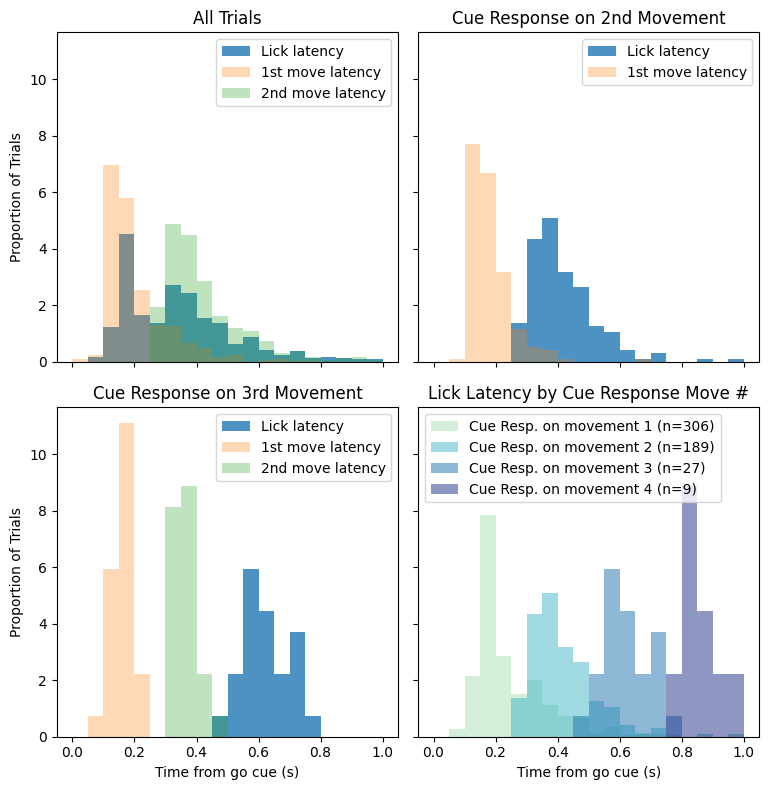

In [9]:
# plotting results: latency of cue response tongue movements, sorted by movement ordinal

# --- Shared settings ---
bins = np.arange(0, 1.05, 0.05)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()

# -------------------------------
# Subplot 1: All trials
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="All Trials", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 2: Cue response on 2nd movement
# -------------------------------
trials_2nd = df.loc[df['cue_response_movement_number'] == 2, 'trial'].unique()
df_2nd = df.query("trial in @trials_2nd and movement_number_in_trial <= 2")

lick_lat = df_2nd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_2nd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']

ax = axes[1]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.set(title="Cue Response on 2nd Movement")
ax.legend()

# -------------------------------
# Subplot 3: Cue response on 3rd movement
# -------------------------------
trials_3rd = df.loc[df['cue_response_movement_number'] == 3, 'trial'].unique()
df_3rd = df.query("trial in @trials_3rd and movement_number_in_trial <= 3")

lick_lat = df_3rd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_3rd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[2]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="Cue Response on 3rd Movement", xlabel="Time from go cue (s)", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 4: Lick latency by cue_response_movement_number (1-4)
# -------------------------------
per_trial = (
    tongue_movements
      .dropna(subset=['lick_latency', 'cue_response_movement_number'])
      .drop_duplicates('trial')                # <- critical: keep a single row per trial
      .copy()
)
lick_latencies_by_cue = (
    per_trial
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

cmap = plt.colormaps['YlGnBu']
colors = cmap(np.linspace(0.3, 0.9, 4))

ax = axes[3]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True, alpha=0.5,
        label=f"Cue Resp. on movement {n} (n={len(latencies)})",
        color=colors[n-1]
    )
ax.set(title="Lick Latency by Cue Response Move #", xlabel="Time from go cue (s)")
ax.legend(loc="upper left")

# --- Final layout ---
fig.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "latency_cue-response_by_movement-ordinal"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")






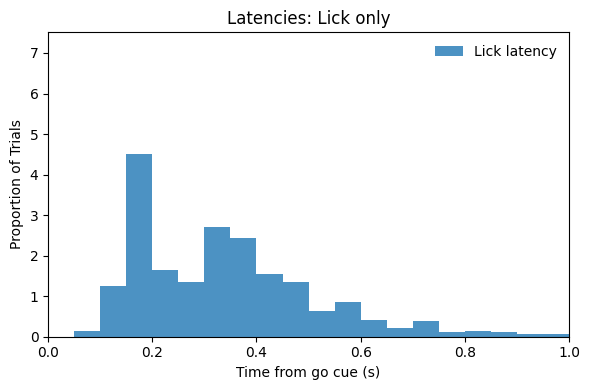

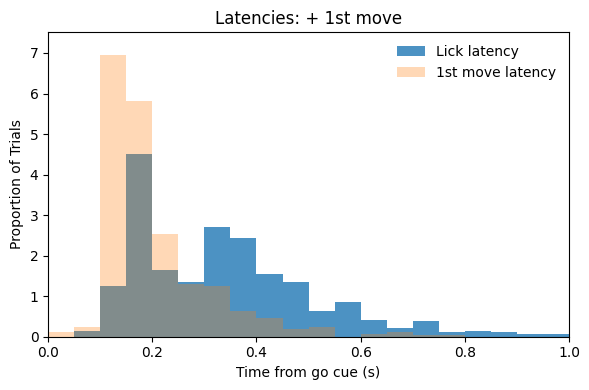

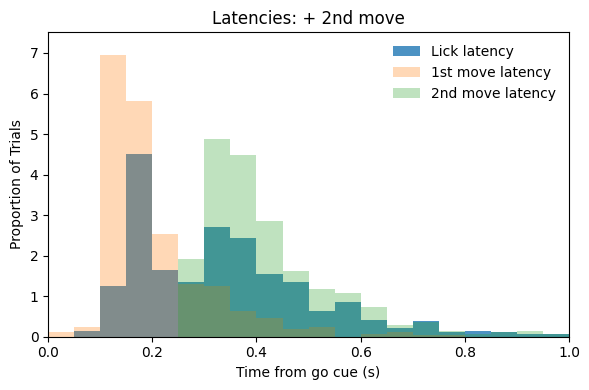

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Settings (match your palette) ---
bins = np.arange(0, 1.05, 0.05)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3
figsize = (6, 4)   # adjust as needed
xlabel = "Time from go cue (s)"
ylabel = "Proportion of Trials"
title_prefix = "Latencies"

# --- Extract latencies ---
df = tongue_movements.copy()

# Lick latency (one per trial)
lick_lat = (
    df.drop_duplicates('trial')['lick_latency']
      .dropna()
)

# Movement latencies ordered within each trial
moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = (
    moves.groupby('trial')
         .nth(0)['movement_latency_from_go']
         .dropna()
)
second_move = (
    moves.groupby('trial')
         .nth(1)['movement_latency_from_go']
         .dropna()
)

# --- Compute shared axis limits ---
# Use density=True like the plots; take the max bin height across all three
def max_density(arr):
    if len(arr) == 0:
        return 0.0
    hist, _ = np.histogram(arr, bins=bins, density=True)
    return hist.max() if len(hist) else 0.0

ymax = max(
    max_density(lick_lat),
    max_density(first_move),
    max_density(second_move),
)
# Add a small headroom so the tallest bar doesn't touch the top
ymax = ymax * 1.08 if ymax > 0 else 1.0

xlim = (bins[0], bins[-1])
ylim = (0, ymax)

# --- Panel A: Lick latency only ---
figA, axA = plt.subplots(figsize=figsize)
axA.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
axA.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: Lick only")
axA.legend(frameon=False)
figA.tight_layout()
if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick_lickonly"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

# --- Panel B: + 1st move latency (superimposed) ---
figB, axB = plt.subplots(figsize=figsize)
axB.hist(lick_lat,   bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],  label="Lick latency")
axB.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
axB.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 1st move")
axB.legend(frameon=False)
figB.tight_layout()
if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick_firstmove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

# --- Panel C: + 2nd move latency (superimposed) ---
figC, axC = plt.subplots(figsize=figsize)
axC.hist(lick_lat,    bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],   label="Lick latency")
axC.hist(first_move,  bins=bins, density=True, alpha=alpha_move, color=colors["first"],  label="1st move latency")
axC.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
axC.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 2nd move")
axC.legend(frameon=False)
figC.tight_layout()
if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick_firstandsecondmove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

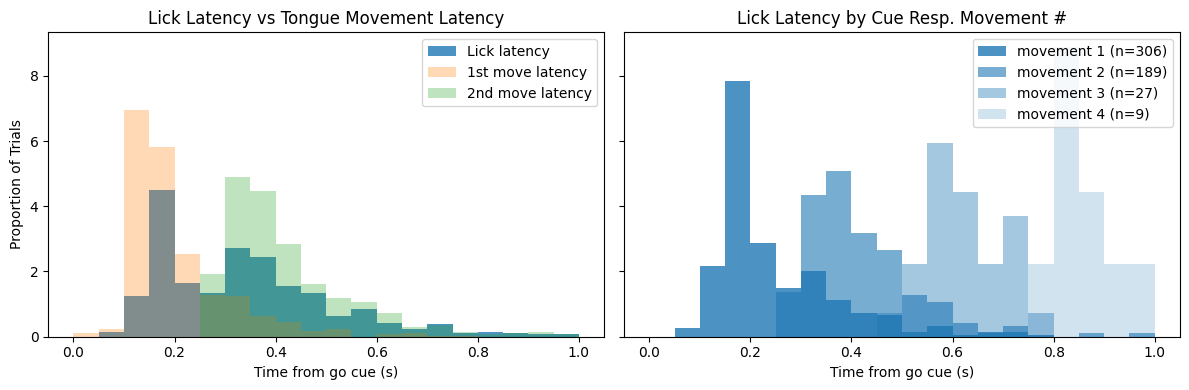

In [ ]:
# --- Shared settings ---
bins = np.arange(0, 1.05, 0.05)
base_colors = {
    "lick": "#1f77b4",   # blue
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

# Make side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# -------------------------------
# Panel 1: All trials (like old subplot 1)
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=base_colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=base_colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=base_colors["second"], label="2nd move latency")
ax.set(title="Lick Latency vs Tongue Movement Latency", ylabel="Proportion of Trials", xlabel="Time from go cue (s)")
ax.legend()

# -------------------------------
# Panel 2: Lick latency by cue_response_movement_number (use one color, vary alpha)
# -------------------------------
# One lick per trial, then group
per_trial = (
    tongue_movements
      .dropna(subset=['lick_latency', 'cue_response_movement_number'])
      .drop_duplicates('trial')                # <- critical: keep a single row per trial
      .copy()
)
lick_latencies_by_cue = (
    per_trial
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

# decreasing alpha with movement number
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

ax = axes[1]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True,
        alpha=alphas.get(n, 0.2),
        label=f"movement {n} (n={len(latencies)})",
        color=base_colors["lick"]
    )
ax.set(title="Lick Latency by Cue Resp. Movement #", xlabel="Time from go cue (s)")
ax.legend(loc="upper right")

# --- Final layout ---
fig.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


Estimated Δt (median IMI): 0.2020 s


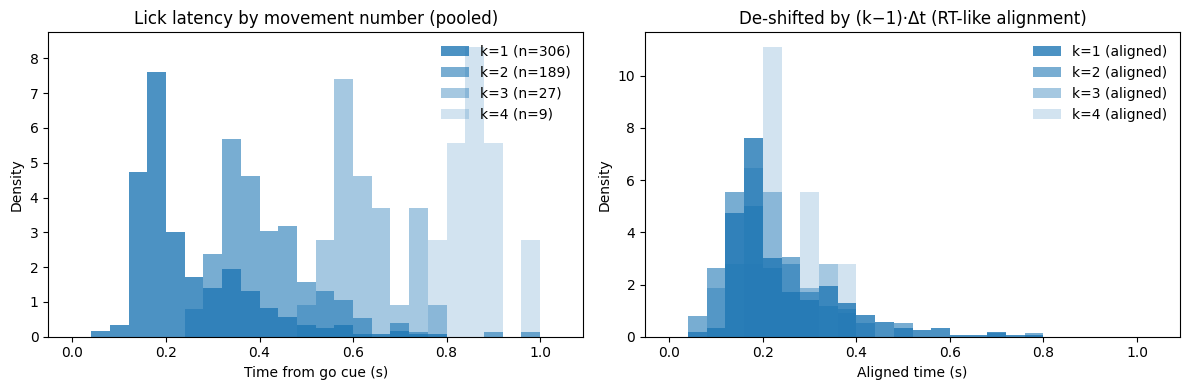


Aligned-shape similarity to k=1 (KS test):
  k=2: KS=0.195, p=0.000217  (n_k=189, n_1=306)
  k=3: KS=0.169, p=0.432  (n_k=27, n_1=306)
  k=4: KS=0.490, p=0.019  (n_k=9, n_1=306)

Aligned medians by k: {1: 0.19790400005877018, 2: 0.18710399977862835, 3: 0.2181440000422299, 4: 0.23731200024485588}
Aligned means by k: {1: 0.2484630588244257, 2: 0.21417583075780716, 3: 0.22328059271805817, 4: 0.26215466691388023}


In [16]:
# === Simple, pandas-style analysis of "RT + IMI" using lick latency conditioned on movement number ===
# Requires `tongue_movements` with columns:
# ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ----------------------------
# 0) Prep: keep movements up to cue-response; one lick per trial
# ----------------------------
df = tongue_movements.copy()

# robust numerics
for c in ['movement_number_in_trial', 'movement_latency_from_go', 'lick_latency', 'cue_response_movement_number']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# keep rows where the cue-response is known and only movements up to that movement
df = df[df['cue_response_movement_number'].notna() &
        (df['movement_number_in_trial'] <= df['cue_response_movement_number'])].copy()

# one lick per trial (avoid duplication from multiple movement rows)
per_trial = (
    df.dropna(subset=['lick_latency','cue_response_movement_number'])
      .drop_duplicates('trial')[['trial','lick_latency','cue_response_movement_number']]
      .rename(columns={'cue_response_movement_number':'k'})
)

# ----------------------------
# 1) Estimate Δt (inter-movement interval) from within-trial gaps
# ----------------------------
# use movement latencies (up to cue-response) and take median diff per trial
mv = (df.dropna(subset=['movement_latency_from_go','movement_number_in_trial'])
        .sort_values(['trial','movement_number_in_trial'])
        [['trial','movement_number_in_trial','movement_latency_from_go']])

imi_diffs = (
    mv.groupby('trial')['movement_latency_from_go']
      .apply(lambda x: np.diff(x.dropna().to_numpy()))
      .tolist()
)
imi_diffs = np.concatenate([d for d in imi_diffs if (isinstance(d, np.ndarray) and d.size > 0)]) \
            if len(imi_diffs) else np.array([])
Delta_t = float(np.median(imi_diffs)) if imi_diffs.size else np.nan

print(f"Estimated Δt (median IMI): {Delta_t:.4f} s")

# ----------------------------
# 2) Distributions of lick latency by movement k
# ----------------------------
bins = np.arange(0, 1.05, 0.04)
lick_blue = "#1f77b4"
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

by_k = (
    per_trial
      .query("k <= 4")  # limit to first 4 for readability; remove if you want all ks
      .groupby('k')['lick_latency']
)

# Panel A: pooled lick-latency histograms by movement number (all same color, varying alpha)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0: 
        continue
    ax[0].hist(arr, bins=bins, density=True, alpha=alphas.get(int(k), 0.2),
               color=lick_blue, label=f"k={int(k)} (n={arr.size})")

ax[0].set(title="Lick latency by movement number (pooled)",
          xlabel="Time from go cue (s)", ylabel="Density")
ax[0].legend(frameon=False)

# ----------------------------
# 3) Align (de-shift) by (k-1)*Δt and compare shapes (RT + IMI check)
# ----------------------------
aligned = []
labels = []
for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0:
        continue
    shifted = arr - (int(k)-1) * Delta_t   # remove the IMI offset
    aligned.append(shifted)
    labels.append(int(k))

# Panel B: aligned histograms (should overlap if model holds)
if aligned:
    # choose common bins for aligned data
    all_aligned = np.concatenate(aligned)
    lo, hi = np.nanmin(all_aligned), np.nanmax(all_aligned)
    pad = 0.02 * (hi - lo) if np.isfinite(hi - lo) and (hi > lo) else 0.05
    aligned_bins = np.arange(lo - pad, hi + pad + 1e-9, 0.04)

    for k, arr in zip(labels, aligned):
        ax[1].hist(arr, bins=bins, density=True, alpha=alphas.get(int(k), 0.2),
                   color=lick_blue, label=f"k={k} (aligned)")

ax[1].set(title="De-shifted by (k−1)·Δt (RT-like alignment)",
          xlabel="Aligned time (s)", ylabel="Density")
ax[1].legend(frameon=False)

fig.tight_layout()
plt.show()

# ----------------------------
# 4) Simple statistics: do aligned distributions match k=1?
# ----------------------------
# KS tests: aligned k vs aligned k=1
ks_results = {}
if len(aligned) and (1 in labels):
    # map labels -> arrays
    aligned_map = {k: arr for k, arr in zip(labels, aligned)}
    base = aligned_map.get(1, np.array([]))
    for k in sorted(aligned_map.keys()):
        if k == 1:
            continue
        a = aligned_map[k]; b = base
        if a.size >= 2 and b.size >= 2:
            stat, p = ks_2samp(a, b, alternative='two-sided', mode='auto')
            ks_results[k] = {'ks_stat': float(stat), 'p': float(p), 'n_k': int(a.size), 'n_base': int(b.size)}

# Print a compact summary
print("\nAligned-shape similarity to k=1 (KS test):")
if ks_results:
    for k, r in ks_results.items():
        print(f"  k={k}: KS={r['ks_stat']:.3f}, p={r['p']:.3g}  (n_k={r['n_k']}, n_1={r['n_base']})")
else:
    print("  Not enough data to compare or only one k present.")

# ----------------------------
# 5) (Optional) quick visual check of mean/median after alignment
# ----------------------------
if aligned:
    med_by_k = {k: float(np.median(arr)) for k, arr in zip(labels, aligned) if arr.size}
    mean_by_k = {k: float(np.mean(arr)) for k, arr in zip(labels, aligned) if arr.size}
    print("\nAligned medians by k:", med_by_k)
    print("Aligned means by k:", mean_by_k)


if SAVE_FIG:
    fname = FIG_DIR / "licklatency_by_movement_number_RTalign"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

Estimated Δt (median IMI): 0.2020 s


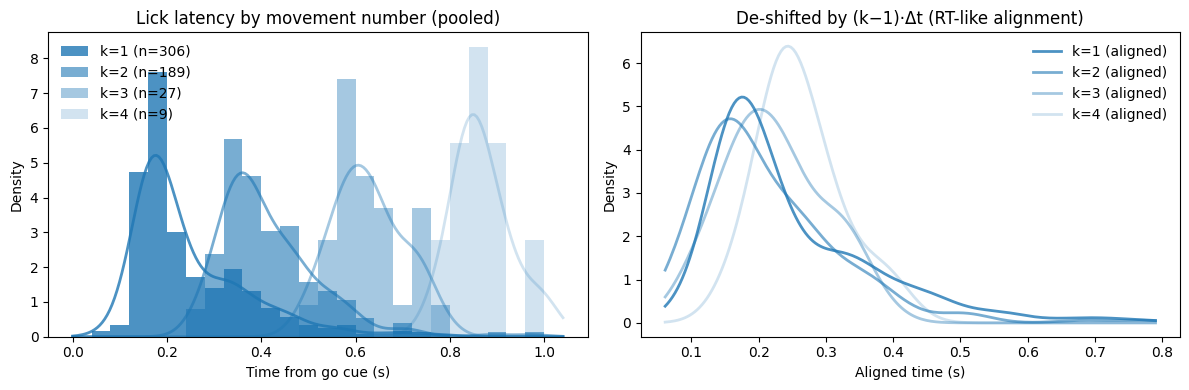


Aligned-shape similarity to k=1 (KS test):
  k=2: KS=0.195, p=0.000217  (n_k=189, n_1=306)
  k=3: KS=0.169, p=0.432  (n_k=27, n_1=306)
  k=4: KS=0.490, p=0.019  (n_k=9, n_1=306)

Aligned medians by k: {1: 0.19790400005877018, 2: 0.18710399977862835, 3: 0.2181440000422299, 4: 0.23731200024485588}
Aligned means by k: {1: 0.2484630588244257, 2: 0.21417583075780716, 3: 0.22328059271805817, 4: 0.26215466691388023}

Propagation of noise (spread vs movement number):


,k,n,mean_latency,std_latency,aligned_mean,aligned_std
0,1,306,0.248463,0.122367,0.248463,0.122367
1,2,189,0.416160,0.106924,0.214176,0.106924
2,3,27,0.627249,0.071678,0.223281,0.071678
3,4,9,0.868107,0.057451,0.262155,0.057451


Linear fit: std ≈ 0.147 + -0.023·k


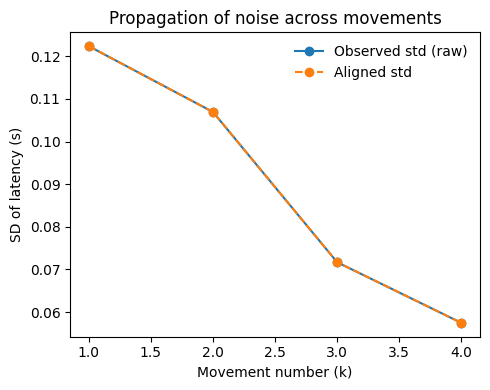

In [18]:
# === Simple, pandas-style analysis of "RT + IMI" using lick latency conditioned on movement number ===
# Requires `tongue_movements` with columns:
# ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, gaussian_kde

# ----------------------------
# 0) Prep: keep movements up to cue-response; one lick per trial
# ----------------------------
df = tongue_movements.copy()

for c in ['movement_number_in_trial', 'movement_latency_from_go', 'lick_latency', 'cue_response_movement_number']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df[df['cue_response_movement_number'].notna() &
        (df['movement_number_in_trial'] <= df['cue_response_movement_number'])].copy()

per_trial = (
    df.dropna(subset=['lick_latency','cue_response_movement_number'])
      .drop_duplicates('trial')[['trial','lick_latency','cue_response_movement_number']]
      .rename(columns={'cue_response_movement_number':'k'})
)

# ----------------------------
# 1) Estimate Δt (inter-movement interval)
# ----------------------------
mv = (df.dropna(subset=['movement_latency_from_go','movement_number_in_trial'])
        .sort_values(['trial','movement_number_in_trial'])
        [['trial','movement_number_in_trial','movement_latency_from_go']])

imi_diffs = (
    mv.groupby('trial')['movement_latency_from_go']
      .apply(lambda x: np.diff(x.dropna().to_numpy()))
      .tolist()
)
imi_diffs = np.concatenate([d for d in imi_diffs if (isinstance(d, np.ndarray) and d.size > 0)]) \
            if len(imi_diffs) else np.array([])
Delta_t = float(np.median(imi_diffs)) if imi_diffs.size else np.nan
print(f"Estimated Δt (median IMI): {Delta_t:.4f} s")

# ----------------------------
# 2) Distributions of lick latency by movement k
# ----------------------------
bins = np.arange(0, 1.05, 0.04)
lick_blue = "#1f77b4"
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

by_k = (
    per_trial
      .query("k <= 4")
      .groupby('k')['lick_latency']
)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

# ----------------------------
# Panel A: histogram + KDE
# ----------------------------
for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0:
        continue
    ax[0].hist(arr, bins=bins, density=True, alpha=alphas.get(int(k), 0.3),
               color=lick_blue, label=f"k={int(k)} (n={arr.size})")
    kde = gaussian_kde(arr)
    xs = np.linspace(bins[0], bins[-1], 200)
    ax[0].plot(xs, kde(xs), color=lick_blue, lw=2, alpha=alphas.get(int(k), 0.5))

ax[0].set(title="Lick latency by movement number (pooled)",
          xlabel="Time from go cue (s)", ylabel="Density")
ax[0].legend(frameon=False)

# ----------------------------
# 3) Align by (k−1)*Δt and compare shapes
# ----------------------------
aligned, labels = [], []
for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0:
        continue
    shifted = arr - (int(k)-1) * Delta_t
    aligned.append(shifted)
    labels.append(int(k))

# ----------------------------
# Panel B: KDE only
# ----------------------------
if aligned:
    all_aligned = np.concatenate(aligned)
    lo, hi = np.nanmin(all_aligned), np.nanmax(all_aligned)
    xs = np.linspace(lo, hi, 200)

    for k, arr in zip(labels, aligned):
        if arr.size == 0:
            continue
        kde = gaussian_kde(arr)
        ax[1].plot(xs, kde(xs), lw=2, alpha=alphas.get(int(k), 0.5),
                   color=lick_blue, label=f"k={k} (aligned)")

ax[1].set(title="De-shifted by (k−1)·Δt (RT-like alignment)",
          xlabel="Aligned time (s)", ylabel="Density")
ax[1].legend(frameon=False)

fig.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "licklatency_by_movement_number_RTalign_kde"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

# ----------------------------
# 4) KS tests vs k=1
# ----------------------------
ks_results = {}
if len(aligned) and (1 in labels):
    aligned_map = {k: arr for k, arr in zip(labels, aligned)}
    base = aligned_map.get(1, np.array([]))
    for k in sorted(aligned_map.keys()):
        if k == 1:
            continue
        a = aligned_map[k]; b = base
        if a.size >= 2 and b.size >= 2:
            stat, p = ks_2samp(a, b)
            ks_results[k] = {'ks_stat': float(stat), 'p': float(p), 'n_k': int(a.size), 'n_base': int(b.size)}

print("\nAligned-shape similarity to k=1 (KS test):")
if ks_results:
    for k, r in ks_results.items():
        print(f"  k={k}: KS={r['ks_stat']:.3f}, p={r['p']:.3g}  (n_k={r['n_k']}, n_1={r['n_base']})")
else:
    print("  Not enough data to compare.")

# ----------------------------
# 5) Quick check of mean/median after alignment
# ----------------------------
if aligned:
    med_by_k = {k: float(np.median(arr)) for k, arr in zip(labels, aligned) if arr.size}
    mean_by_k = {k: float(np.mean(arr)) for k, arr in zip(labels, aligned) if arr.size}
    print("\nAligned medians by k:", med_by_k)
    print("Aligned means by k:", mean_by_k)


# --- Add after section 5 in your current analysis notebook cell ---

# ----------------------------
# 6) Propagation of noise: does variance increase with k?
# ----------------------------
if aligned:
    # collect unaligned and aligned stds
    stats = []
    for k, series in by_k:
        arr = series.dropna().to_numpy()
        if arr.size == 0:
            continue
        aligned_arr = arr - (int(k)-1) * Delta_t
        stats.append({
            'k': int(k),
            'n': len(arr),
            'mean_latency': np.mean(arr),
            'std_latency': np.std(arr),
            'aligned_mean': np.mean(aligned_arr),
            'aligned_std': np.std(aligned_arr)
        })
    stats_df = pd.DataFrame(stats).sort_values('k')
    print("\nPropagation of noise (spread vs movement number):")
    display(stats_df)

    # simple linear regression: does std increase with k?
    if len(stats_df) >= 2:
        slope, intercept = np.polyfit(stats_df['k'], stats_df['std_latency'], 1)
        print(f"Linear fit: std ≈ {intercept:.3f} + {slope:.3f}·k")

    # plot variance growth
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(stats_df['k'], stats_df['std_latency'], 'o-', label='Observed std (raw)')
    ax.plot(stats_df['k'], stats_df['aligned_std'], 'o--', label='Aligned std')
    ax.set(xlabel='Movement number (k)', ylabel='SD of latency (s)',
           title='Propagation of noise across movements')
    ax.legend(frameon=False)
    fig.tight_layout()



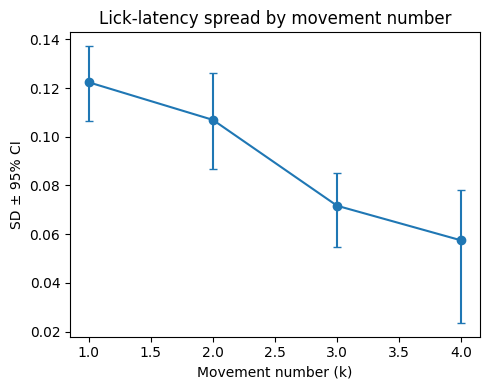

In [14]:
import numpy as np

def bootstrap_std_ci(data, n_boot=1000, alpha=0.05):
    if len(data) < 5:
        return np.nan, np.nan
    boot = [np.std(np.random.choice(data, len(data), replace=True)) for _ in range(n_boot)]
    return np.percentile(boot, [100*alpha/2, 100*(1-alpha/2)])

stats_df['std_ci_low'], stats_df['std_ci_high'] = zip(*[
    bootstrap_std_ci(per_trial.query("k == @k")['lick_latency'].dropna().to_numpy())
    for k in stats_df['k']
])
fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(stats_df['k'], stats_df['std_latency'],
             yerr=[stats_df['std_latency'] - stats_df['std_ci_low'],
                   stats_df['std_ci_high'] - stats_df['std_latency']],
             fmt='o-', capsize=3)
ax.set(xlabel='Movement number (k)', ylabel='SD ± 95% CI',
       title='Lick-latency spread by movement number')
fig.tight_layout()


I think this is because there are EVEN MORE 'covert' preparatory tongue movements occuring in k=1 and k=2 in particular. you can see secondary 'bump' in the distributions.